ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **13May21**

# 11. Peclet Coupled 1D with Dirichlet Boundary Conditions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Plotting Functions](#plotting)
<br><br>
1. [Problem Statement](#problem)
 + [Strong Form](#dbcstrong)
 + [Weak Form](#dbcweak)
 + [Poisson-Dirichlet Energy](#energy)
<br><br>
1. [Problem Solution](#solution)
 + [Code a Convective Term Kernel](#dbcdiff)
 + [Compile and Link Application](#compile1)
 + [Input File](#dbcinput)
 + [Run Application](#dbcrun)
<br><br>   
1. [Linear Lagrange FEM Results](#dbclinearfemresults)
 + [Compute Error](#linearerror)
<br><br>    
1. [Quadratic Lagrange FEM Results](#dbcquadfemresults)
 + [Compute Error](#quaderror)
<br><br>    
1. [High Peclet Number](#highpe)
 + [Quadratic Lagrange FEM Results](#highperesults1)
    - [Compute Error](#highperesults1error)
 + [Quadratic Lagrange FEM Results](#highperesults2)
    - [Compute Error](#highperesults2error)
<br><br>   
1. [Application Tree](#tree)
---

## [Objectives](#toc)<a id="obj"></a>

+ Introduce a convective term in the Poisson problem studied in the notebook series 06; all past notebooks must be thoroughly reviewed.
+ Introduce the Galerkin weak form of the Peclet 1D problem below ([OneNote notes here](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eib-vZHIpRlPlOMtz0Gf_asBegEFKsl9dOK4nHyDbgSeUA?e=sLu1td)).
+ <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. A significant effort in programing is often necessary to learn the subject well. However the material in this course is helpful with this task. Hands-on work during lectures will try to fill in existing gap. The steps in this notebook are necessary for a basic understanding of the subject.</span> 
+ The reader is supposed to consult the [`MOOSE source documentation`](https://mooseframework.inl.gov/source/index.html) to fill in gaps in reproducing the steps below.</span>

## [Plotting Functions](#toc)<a id="plotting"></a>

This is an auxiliary section for holding plotting functions used later.

In [25]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  u1_legend='no u1 legend',
                  u2_legend='no u2 legend',
                  u1_flux_legend='no u1 flux legend',
                  u2_flux_legend='no u2 flux legend'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(15, 6))

    ax1.plot(df['x'], df['u'],'r*-',label=u1_legend)
    
    if 'u2' in df.columns:
        ax1.plot(df['x'], df['u2'],'r*--',label=u2_legend)

    ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
    ax1.set_ylabel(r'$u_h(x)$ [g/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    if 'diffFluxU_x' in df.columns:
        # create a twin x axis to be shared
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_x'],'*-', color='yellow', label=u1_flux_legend)
        
        if 'diffFluxU2_x' in df.columns:
            ax2.plot(df['x'], df['diffFluxU2_x'],'*--', color='yellow', label=u2_flux_legend)

        ax2.set_ylabel(r"$q_h(x)$ [g/cm$^2$-s]", fontsize=16, color='yellow')
        ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        #ax2.set_ylim(0,2)
        #ax2.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

## [Problem Statement](#toc)<a id="problem"></a>

The following sections describe an extension of the Peclet problem described in previous notebooks for the case when two fields are coupled through a source term.

### [Strong Form of Problem Statement](#toc)<a id="dbcstrong"></a>

Solve the Peclet model problem. Find $u_1:[a,b]\subset\Reals\rightarrow\Reals$ and $u_2:[a,b]\subset\Reals\rightarrow\Reals$ for $D_1 > 0$ and $D_2 > 0$ such that:

\begin{align*}
  v\, u_1' &= -\bigl(-D_1\, u_1'\bigr)'(x) + S(u_1, u_2) \quad \forall \quad x\in [a,b], \\
 u_1(a) &= A_1, \\
 u_1(b) &= B_1.
\end{align*}

and

\begin{align*}
  v\, u_2' &= -\bigl(-D_2\, u_2'\bigr)'(x) - S(u_1, u_2) \quad \forall \quad x\in [a,b], \\
 u_2(a) &= A_2, \\
 u_2(b) &= B_2.
\end{align*}

The *diffusion flux* associated to the quantity $u_i, \, \ i=1,2$ is denoted $q_i := -D_i\,u_i'$, and it is often of interest as a derived quantity. Here a point-wise *convective sink (or sweep)* is given by $v\,u_i'$. There exists two Peclet numbers: 

  + Peclet number: $\frac{v\,L}{D_i}$. 

whose effects has been described in earlier notebooks.

Likewise in the single-field Peclet 1-D problem (Notebook 10), the values of the dependent variables are given on the two end points of the domain (*essential* boundary conditions or  *Dirichlet boundary conditions*).

### [Coupling Source](#toc)<a id="couplingsource"></a>

Consider the following coupling source:

\begin{align*}
 S(u_1, u_2) = S_1 - h_1\,\bigl(u_1-u_1^*\bigr) - \Bigl( S_2 - h_2\, \bigl(u_2 - u_2^*\bigr) \Bigr)
\end{align*}

Where 

### [Weak Form of the Problem Statement](#toc)<a id="dbcweak"></a>

The Galerkin weak formulation is as follows. Find $u_1 \in H^1\!\bigl([a,b]\bigr)$ and $u_2 \in H^1\!\bigl([a,b]\bigr)$
so that 

\begin{align*}
 \int\limits_a^b v\, u_1'(x)\, w(x)\,dx + \int\limits_a^b D\, u_1'(x)\,w'(x)\,dx - \int\limits_a^b S(u_1, u_2)\,w(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), \text{and}
 \\
  \int\limits_a^b v\, u_2'(x)\, w(x)\,dx + \int\limits_a^b D\, u_2'(x)\,w'(x)\,dx + \int\limits_a^b S(u_1, u_2)\,w(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr),
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\subset\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty\bigr\}$ and $H^1_0\!\bigl([a,b]\bigr) := \bigl\{ w \mid w \in H^1(a,b), w(a) = 0, w(b) =0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $w$ is called a test function. Because $w$, $u_1$, $u_2$ are sought in very similar sets of functions, this weak form is called Galerkin's weak form.

The new convective integral term is the key term to be computed. Since the MOOSE framework performs the integration, and provides the implementation of the test function, we need to provide the integrand of the integral, that is, the kernel. Therefore the kernel needed is:

 1. $v\,u'(x)\,\,w(x)$.
 
The kernels are to be evaluated at quadrature points provided by the MOOSE framework.

## [Problem Solution](#toc)<a id="solution"></a>

We will leverage the Peclet 1D development (Notebook 09) to modify the source term where the coupling takes place.

### [Code a Source Term Kernel](#toc)<a id="dbcsource"></a>

1. Starting from the Peclet 1D development.

 + You will need to declare a member variable named `_sourceS` as `Real` data type. For example:
   ```c++
   /// The variable which holds the value for the source
   const Real _sourceS;
   ```
1. Create a `SourceTerm.C` class implementation likewise.
 + Use the `EquationTerm.C` course template.
 + You will need to program the *residual* and *Jacobian* methods. <span style="color:red">This portion of the implementation is covered in class.</span>
 
 + For the residual, a return value such as this is needed:
  ```c++
  Real
  SourceTerm::computeQpResidual()
  {
   return _sourceS * _test[_i][_qp];
  }
  ```
 + For the Jacobian, a return value such as this is needed:
 ```c++
 Real
 SourceTerm::computeQpJacobian()
 {
  return 0.0;
 }
 ```


### [Compile and Link Application](#toc)<a id="compile1"></a>

1. Make sure you are in the problem project:
 +  `cd ../..`
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

### [Input File](#toc)<a id="dbcinput"></a>

A new kernel block needs to be added to the input file (review Notebook 06 series); in addition the velocity is added as a vector valued quantity in preparation for 2-D and 3-D extensions.

Some additional info on `MOOSE` **Hierarchical Input Text** (HIT) syntax can be found [here](https://mooseframework.inl.gov/application_usage/input_syntax.html).
```
# Parameters
velocity = '4.00000e-02 0.00000e+00 0.00000e+00'

[Kernels]
  [convection-term]
    type = ConvectionTerm   # New convective term
    variable = u     
    velocity = ${replace velocity}
  []
[]
```
Save the input file in the `.../engy5310p1/` directory.

### [Run Application](#toc)<a id="dbcrun"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.hit`
2. Compare your results with this notebook results below.
3. Return here to follow instructions on how to implement the calculation of the total energy.

## [Linear Lagrange FEM](#toc)<a id="dbclinearfemresults"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s
> + Pe = 10

FEM parameters:

> + Basis Functions: First Order Lagrangian
> + num. of finite elements: 10

In [2]:
'''Domain'''

x_a = 0
x_b = 25

x_length = x_b - x_a

In [58]:
'''Parameters and data'''

Pe = 10 # mildly convective dominated

diff_coeff_1 = 0.1
source_s_1 = 1e-3
source_transfer_coeff_1 = 5e-3
source_saturation_1 = 1.5

diff_coeff_2 = 2*diff_coeff_1
source_s_2 = 0.1*source_s_1
source_transfer_coeff_2 = .5*source_transfer_coeff_1
source_saturation_2 = 2

velocity = (Pe * (diff_coeff_1+diff_coeff_2)/2/x_length, 0, 0)  # length scale is the x length

u_a = 3
u_b = 0

u2_a = 0
u2_b = 0

In [59]:
'''FEM Solution'''

n_felem = 10

order = 'first'

n_plot_pts = n_felem + 1

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, 
                                u_left=u_a, u_right=u_b, 
                                diff_coeff=diff_coeff, source_s=source_s_1,
                                source_transfer_coeff=source_transfer_coeff_1, 
                                source_saturation=source_saturation_1,
                                u2_left=u2_a, u2_right=u2_b, 
                                diff_coeff_2=diff_coeff_2, source_s_2=-source_s_2,
                                source_transfer_coeff_2=-source_transfer_coeff_2, 
                                source_saturation_2=source_saturation_2,
                                velocity=velocity, 
                                n_felem=n_felem, order=order, 
                                n_plot_pts=n_plot_pts,
                                compute_diffusion_flux=True)

In [60]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 19Apr21 23:46:34

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
source_transfer_coeff = 5.00000e-03
source_saturation = 1.50000e+00
u_left = 3.00000e+00
u_right = 0.00000e+00
u2_left = 0.00000e+00
u2_right = 0.00000e+00
diff_coeff_2 = 2.00000e-01
source_s_2 = -1.00000e-04
source_transfer_coeff_2 = -2.50000e-03
source_saturation_2 = 2.00000e+00
velocity = '6.00000e-02 0.00000e+00 0.00000e+00'

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 10
  []
[]

[Variables]
  [u]
    order = first
    family = lagrange
    initial_condition = ${fparse (u_right+u_left)/2}
  []
  [u2]
    order = first
    family = lagrange
    initial_condition = ${fparse (u2_right+u2_left)/2}
  []
[]

[AuxVariables]
  [diffFl

In [61]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Mon Apr 19 23:46:35 2021
Executable Timestamp:    Mon Apr 19 21:44:00 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 11
    Local:                 11
  Elems:                   
    Total:                 10
    Local:                 10
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                22
  Num Local DOFs:          22
  Variables:               { "u" "u2" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Auxiliary System:
  Num DOFs:                40
  Num Local DOFs:          40


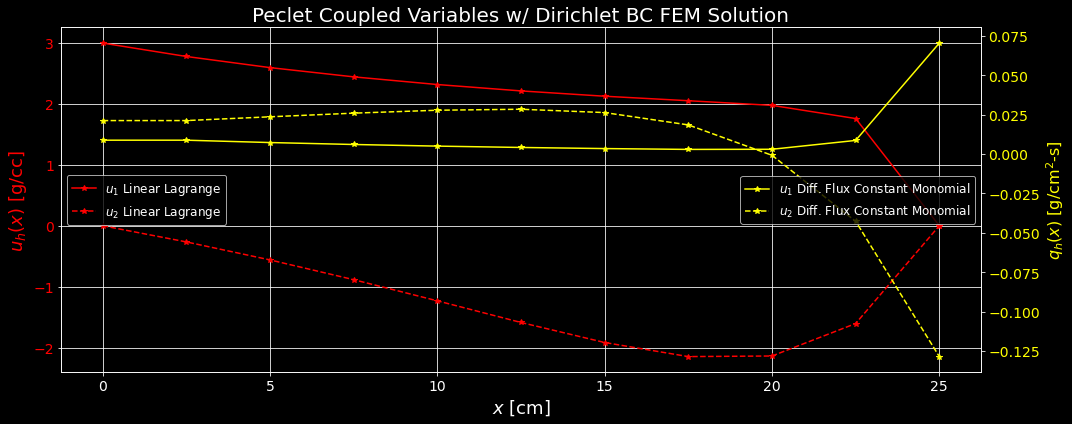

In [62]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')
    
plot_solution(df, title='Peclet Coupled Variables w/ Dirichlet BC FEM Solution', 
              u1_legend=r'$u_1$ Linear Lagrange', u2_legend=r'$u_2$ Linear Lagrange',
              u1_flux_legend=r'$u_1$ Diff. Flux Constant Monomial',
              u2_flux_legend=r'$u_2$ Diff. Flux Constant Monomial')

**Comments:**

1. The *concentration* is "swept" to the right and rises towards the exit before dropping to the boundary value.
1. Because of convection, a boundary layer will form near the exit as Pe increases.
1. An adequate number of finite element basis functions are needed to capture the correct behavior of $u$.
1. The normal diffusion flux on both ends of the domain is positive, therefore the exists diffusive *draining* on both boundaries.

### [FEM Error](#toc)<a id="linearerror"></a>

In [ ]:
'''Error Compared to Exact Dimensionless Solution'''

'''coming...'''

**Comments:**

1. TBA
1. TBA

## [Quadratic Lagrange FEM](#toc)<a id="dbcquadfemresults"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s
> + Pe = 10

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 10

The input file needs changes to select the higher order approximation:

```
[Mesh]
 [1d]                                # any lower case name; this is our 1D block
  type = GeneratedMeshGenerator  
  dim = 1 
  xmin = 0 
  xmax = 25
  nx = 1 
  elem_type = edge3                  # this goes with the second order Lagrange basis functions below
 []
[]

[Variables]
 [u]                                 # our unknown variable to be related to below
  order = second                     # MOOSE second order Lagrange basis functions
  family = lagrange
 []
[]
```

In [ ]:
'''FEM Solution'''

n_felem = 10

order = 'second'

n_plot_pts = 2*n_felem + 1

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, u_left=u_a, u_right=u_b, 
                                diff_coeff=diff_coeff, source_s=source_s,
                                source_transfer_coeff=0.005, source_saturation=1.5,
                                velocity=velocity, 
                                n_felem=n_felem, order=order, 
                                n_plot_pts=n_plot_pts,
                                compute_diffusion_flux=True)

In [ ]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

In [ ]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit

In [ ]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

### [FEM Error](#toc)<a id="quaderror"></a>


In [ ]:
'''Error Compared to Exact Dimensionless Solution'''

'''comming...'''

**Comments:**

1. TBA

## [High Peclet Number](#toc)<a id="highpe"></a>

Highly convective problems lead to numerical difficulties. Below, artificial (numerical) oscillations are present near a boundary. 

### [Quadratic Lagrange FEM](#toc)<a id="highperesults1"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s
> + Pe = 50

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 10

In [ ]:
'''Parameters and data'''

Pe = 50 # convective dominated

velocity = (Pe * diff_coeff/x_length, 0, 0)

In [ ]:
'''FEM Solution'''

n_felem = 10

order = 'second'

n_plot_pts = 2*n_felem + 1

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left, x_right, u_left=u_left, u_right=u_right, 
                                diff_coeff=diff_coeff, source_s=source_s, velocity=velocity,
                                n_felem=n_felem, order=order, 
                                n_plot_pts=n_plot_pts, 
                                compute_diffusion_flux=True)

In [ ]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

In [ ]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit

In [ ]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

**Comments:**

As convection dominates, the boundary layer sharpens and *numerical wiggles* appear. This effect is often interpreted as a *numerical instability*. It can be treated by:

 1. Using additional finite element basis functions (not scalable) 
 2. Adapting the mesh (mesh adaptivity); involved but doable
 3. "Stabilizing the weak formulation" or other methods called artificial viscosity or flux "upwinding"

#### [Compute Error](#toc)<a id="highperesults1error"></a>


In [ ]:
'''Flux Error Compared to Exact Dimensionless Solution'''

'''coming...'''

### [Quadratic Lagrange FEM](#toc)<a id="highperesults2"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s
> + Pe = 50

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 10

In [ ]:
'''FEM Solution'''

n_felem = 10

x_bias = 0.5  # mesh adaptivity

order = 'second'

n_plot_pts = 2*n_felem + 1
n_plot_pts *= 2

try:    
    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left, x_right, u_left=u_left, u_right=u_right, 
                                diff_coeff=diff_coeff, source_s=source_s, velocity=velocity,
                                n_felem=n_felem, x_bias=x_bias, order=order, 
                                n_plot_pts=n_plot_pts, 
                                compute_diffusion_flux=True)

In [ ]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

In [ ]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit

In [ ]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

**Comments:**

1. The mesh adaptivity with refinement on the right side of the domain captures the exit boundary layer. An increase of the number of finite element would also correct the oscillation issue but this strategy is often undesirable.

#### [Compute Error](#toc)<a id="highperesults2error"></a>

In [ ]:
'''Error Compared to Exact Dimensionless Solution'''

'''coming'''

## [Application Tree](#toc)<a id="tree"></a>

This tree printout helps the understanding of various pieces of the `MOOSE` application repository created after all the above steps including future implementations in the notebooks following the present one that cover various boundary conditions.

In [ ]:
!tree engy5310p1